## Imports and Parameters

In [1]:
import tensorflow as tf
from tensorflow import keras
import pickle
import os
import numpy as np
from NozPiker_Funcs import main as NZ
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
from IPython.display import clear_output
from livelossplot import PlotLossesKeras

In [2]:
%load_ext autoreload
%autoreload 2


In [2]:
# Define Data Path
DATA_DIR = '/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec_only/'

# Fetching pdbs and converting to images

In [20]:
MRC_PATHS = glob.glob(DATA_DIR + '*mrcs')

In [21]:
len(MRC_PATHS)

39

In [22]:
def GetImageSet(mrc,store):
    from mrcfile import open
    name = mrc.split('/')[-1].split('_')[0]
    ID = mrc.split('/')[-1].split('_')[1]
    with open(mrc,'r') as m:
        data = []
        for i in range(m.data.shape[0]):
            data.append(m.data[i,:,:])
    size = len(data[-1][:,0])
    for image in range(len(data)):
        store[(name, ID, image)] = data[image]
    return size

In [23]:
store = {}
MXSZ = 0
for MRC in MRC_PATHS:
    size = GetImageSet(MRC,store)
    if size > MXSZ:
        MXSZ = size

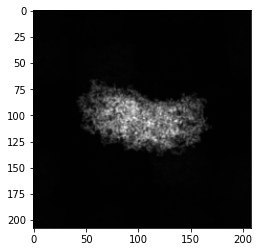

In [24]:
plt.imshow(store[('TUBULIN', '1FFX',4)], cmap=plt.cm.binary_r)
plt.show()

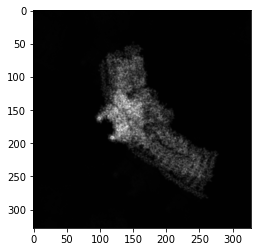

In [25]:
plt.imshow(store[('CLATHRINHEAVYCHAIN', '6SCT', 26)], cmap=plt.cm.binary_r)
plt.show()

In [26]:
def CreateTrainingData(store, size, percent_test):
    from numpy import array, where, zeros, min, max, resize, transpose, floor
    from tensorflow_core.image import resize_with_crop_or_pad
    import random
    # Get Dict keys
    class_names = list(set([key[0] for key in store]))
    # Pre-allocate arrays
    length = 30
    shape = (size,size)
    test_length = int(len(store)*percent_test)
    test_set = dict(random.sample(store.items(), test_length))
    train_set = {key: store[key] for key in store if key not in list(test_set.keys())}
    test_images = []
    test_labels = []
    for k, v in test_set.items():
        array = v
        array = resize(array,(array.shape[0],array.shape[1],1))
        array = resize_with_crop_or_pad(array,size,size)
        array = transpose(array,(2,0,1))
        test_images.append(array)
        test_labels.append(class_names.index(k[0]))

    #test_images = np.asarray(test_images)
    test_images = np.concatenate(test_images)
    test_images = test_images.astype('uint8')
    test_labels = np.asarray(test_labels)
    
    train_images = []
    train_labels = []
    for k, v in train_set.items():
        array = v
        array = resize(array,(array.shape[0],array.shape[1],1))
        array = resize_with_crop_or_pad(array,size,size)
        array = transpose(array,(2,0,1))
        train_images.append(array)
        train_labels.append(class_names.index(k[0]))

    #train_images = np.asarray(train_images)    
    train_images = np.concatenate(train_images)
    train_images = train_images.astype('uint8')
    train_labels = np.asarray(train_labels)
        
    
    return train_images, train_labels, test_images, test_labels, class_names

In [27]:
# divides image data into train-test set given a percentage of data wanted in the test set
train_images, train_labels, test_images, test_labels, class_names = CreateTrainingData(store, MXSZ, 0.3)

In [28]:
# checking the class names of the complexes in the set
class_names

['AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA',
 'DYNEIN',
 '26SPROTEASOME',
 'ATPDEPENDENTMOLECULARCHAPERONEHSP82',
 'CLATHRINHEAVYCHAIN',
 '60KDAHEATSHOCKPROTEINMITOCHONDRIAL',
 'TUBULIN',
 'DYNAMIN1']

In [13]:
train_images.shape

(819, 784, 784)

# The size of the images is too lage so we downsample

In [14]:
train_images_sm = np.zeros((len(train_images), 100, 100))

for idx in range(len(train_images)):
    img = train_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    train_images_sm[idx, :, :] = img_sm

In [15]:
test_images_sm = np.zeros((len(test_images), 100, 100))

for idx in range(len(test_images)):
    img = test_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    test_images_sm[idx, :, :] = img_sm

In [16]:
train_images_sm.shape

(819, 100, 100)

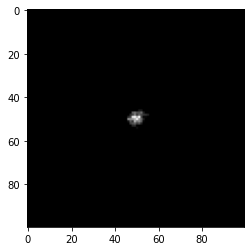

In [17]:
plt.imshow(train_images_sm[100], cmap=plt.cm.binary_r)
plt.show()

In [18]:
test_images_sm.shape

(351, 100, 100)

## Creating a basic Model

In [19]:
# Define model
def create_model():
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(100,100)),
        keras.layers.Dense(1000,activation='relu'),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dense(len(class_names))
    ])
    
    model.compile(optimizer = 'adam',
                  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
    return model


In [20]:
# Create a basic model instance
model = create_model()

# log_dir = "Logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              10001000  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
Total params: 10,130,160
Trainable params: 10,130,160
Non-trainable params: 0
_________________________________________________________________


# We try looping through a more complex model

In [ ]:
# this adds an extra dimension to the data to fit the model needs
train_images_sm = np.asarray(train_images_sm).reshape((819, 100, 100, 1))
test_images_sm = np.asarray(test_images_sm).reshape((351, 100, 100, 1))


In [ ]:
test_images_sm.shape

In [ ]:
import time

denselayers = [0, 1, 2]
layersizes = [32, 64, 128]
convlayers = [1, 2, 3]

for denselayer in denselayers:
    for layersize in layersizes:
        for convlayer in convlayers:
            NAME = "{}_conv_{}_nodes_{}_dense_{}".format(convlayer, layersize, denselayer, int(time.time()))
            print(NAME)
            
            model = keras.models.Sequential()

            model.add(keras.layers.Conv2D(layersize, (3,3),input_shape=[100,100,1]))
            model.add(keras.layers.Activation('relu'))
            model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

            for l in range(convlayer-1):
                model.add(keras.layers.Conv2D(layersize, (3,3)))
                model.add(keras.layers.Activation('relu'))
                model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

            model.add(keras.layers.Flatten())

            for l in range(denselayer):
                model.add(keras.layers.Dense(layersize))
                model.add(keras.layers.Activation('relu'))
                
            model.add(keras.layers.Dense(len(class_names)))
            model.add(keras.layers.Activation('sigmoid'))
            
            tensorboard = tf.keras.callbacks.TensorBoard(log_dir=DATA_DIR+'logs/{}'.format(NAME))
            
            model.compile(optimizer = 'adam',
                  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics = ['accuracy'])
            
            model.fit(train_images_sm,
              train_labels,
              epochs=5,
              validation_data = (test_images_sm,test_labels),
              callbacks=[PlotLossesKeras()])

## Train Model this can be used with either of the above models

In [21]:
import time
NAME = "tetts_basic_nn_{}".format(int(time.time()))

In [22]:
checkpoint_path = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'checkpoints/cp.ckpt')
checkpoint_dir = os.path.dirname(checkpoint_path)

In [23]:
# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

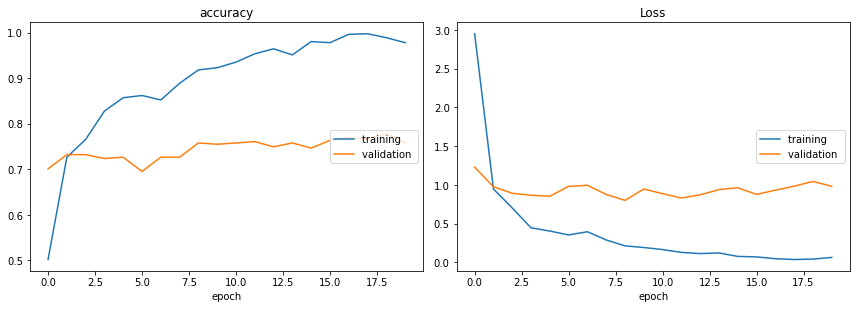

accuracy
	training         	 (min:    0.502, max:    0.998, cur:    0.978)
	validation       	 (min:    0.695, max:    0.778, cur:    0.758)
Loss
	training         	 (min:    0.036, max:    2.951, cur:    0.063)
	validation       	 (min:    0.800, max:    1.228, cur:    0.981)
819/819 [==============================] - 2s 2ms/sample - loss: 0.0627 - accuracy: 0.9780 - val_loss: 0.9815 - val_accuracy: 0.7578


In [24]:
model.fit(train_images_sm,
          train_labels,
          epochs=20,
          validation_data = (test_images_sm,test_labels),
          callbacks=[PlotLossesKeras()])

In [ ]:
os.path.dirname(os.path.dirname(DATA_DIR))

In [ ]:
# Save Model as Hd5
MODEL_DIR = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'models')
model.save(os.path.join(MODEL_DIR,'Multi_Train.h5', 'w'))

## Load Trained Model

In [13]:
# Load the model
MODEL_DIR = os.path.join(os.path.dirname(os.path.dirname(DATA_DIR)),'models')
model = keras.models.load_model(os.path.join(MODEL_DIR,'Multi_Train.h5', 'w'))

# Prepare validation on real data

In [4]:
VAL_DIR = '/home/cns-mccafferty/NozPiker/data/tetts_F15_massSpec/validation/'

In [5]:
MRC_PATHS = glob.glob(VAL_DIR + '*mrcs')

In [6]:
store = {}
MXSZ = 0
for MRC in MRC_PATHS:
    size = GetImageSet(MRC,store)
    #size = NZ.GetImageSet(MRC,store)
    if size > MXSZ:
        MXSZ = size

In [7]:
from numpy import array, where, zeros, min, max, resize, transpose, floor
from tensorflow_core.image import resize_with_crop_or_pad
import random
# Get Dict keys
val_class_names = list(set([key[0] for key in store]))
# Pre-allocate arrays
size= 784
length = 20
shape = (size,size)

val_labels = []
val_images = []
for k, v in store.items():
    array = v
    array = resize(array,(array.shape[0],array.shape[1],1))
    array = resize_with_crop_or_pad(array,size,size)
    array = transpose(array,(2,0,1))
    val_images.append(array)
    val_labels.append(val_class_names.index(k[0]))

#test_images = np.asarray(test_images)
val_images = np.concatenate(val_images)
val_images = val_images.astype('uint8')
#val_labels = np.asarray(test_labels)


In [8]:
val_class_names

['CLATHRIN', 'DYNAMIN', '26SPROTEASOME']

In [9]:
val_images.shape

(60, 784, 784)

In [10]:
val_images_sm = np.zeros((len(val_images), 100, 100))


for idx in range(len(val_images)):
    img = val_images[idx, :, :]
    img_sm = cv2.resize(img, (100, 100), interpolation=cv2.INTER_CUBIC)
    val_images_sm[idx, :, :] = img_sm

In [11]:
val_images_sm.shape

(60, 100, 100)

In [14]:
prediction = model.predict(val_images_sm)

In [15]:
prediction.shape

(60, 8)

In [16]:
np.argmax(prediction[0])

7

In [29]:
for i in prediction:
    print(class_names[np.argmax(i)])


DYNAMIN1
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
DYNAMIN1
ATPDEPENDENTMOLECULARCHAPERONEHSP82
ATPDEPENDENTMOLECULARCHAPERONEHSP82
DYNAMIN1
DYNAMIN1
DYNAMIN1
26SPROTEASOME
ATPDEPENDENTMOLECULARCHAPERONEHSP82
DYNAMIN1
ATPDEPENDENTMOLECULARCHAPERONEHSP82
DYNAMIN1
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
ATPDEPENDENTMOLECULARCHAPERONEHSP82
DYNAMIN1
DYNAMIN1
DYNAMIN1
ATPDEPENDENTMOLECULARCHAPERONEHSP82
ATPDEPENDENTMOLECULARCHAPERONEHSP82
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
ATPDEPENDENTMOLECULARCHAPERONEHSP82
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
DYNAMIN1
DYNAMIN1
DYNEIN
ATPDEPENDENTMOLECULARCHAPERONEHSP82
TUBULIN
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
TUBULIN
TUBULIN
DYNAMIN1
AMINOACYLTRNASYNTHASECOMPLEXINTERACTINGMULTIFUNCTIONA
DYNAMIN1
ATPDEPENDENTMOLECULARCHAPERONEHSP82
ATPDEPENDENTMOLECULARCHAPERONEHSP82
C

In [ ]:
class_names[13]

In [ ]:
MRC_PATHS

In [ ]:
store